In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

data = pd.read_csv("dados_classificacao/dados.csv", sep=',')

In [ ]:
data.dtypes.value_counts()

In [ ]:
df_uniques = pd.DataFrame([[i, len(data[i].unique())] for i in data.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
for cl in data.columns:
    if data[cl].dtypes==np.object0:
        data[cl] = le.fit_transform(data[cl])

data.dtypes.value_counts()
# from sklearn.preprocessing import OneHotEncoder

# categorical_cols = data.select_dtypes(include=['object']).columns

# encoder = OneHotEncoder(sparse=False)
# encoded_data = encoder.fit_transform(data[categorical_cols])

# encoded_df = pd.concat([data.drop(categorical_cols, axis=1),
#                         pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))],
#                        axis=1)
# data = encoded_df

int64    18
dtype: int64

In [ ]:
mapeamento = {coluna: f'var_{i+1}' for i, coluna in enumerate(data.columns)}
# Renomear as colunas com o mapeamento
data.rename(columns=mapeamento, inplace=True)

In [ ]:
data.info()

In [ ]:
data.head()

In [ ]:
data.isna().sum()

In [ ]:
data.isna().any()

In [3]:
X = data.drop(["COMPARECEU_AGENDAMENTO_EXAME","CIDADE"], axis=1)
y = data["COMPARECEU_AGENDAMENTO_EXAME"]

In [ ]:
sns.set(style = 'ticks', color_codes=True)
sns.pairplot(data=data, vars = ["CONSULTAS_ANO_ANTERIOR","CONSULTAS_AUSENTES_ANO_ANTERIO","AGENDAMEN_EXAMES_ANO_ANTERIOR","AGENDA_EXAMES_AUSENTES_ANO_ANT","DISTÂNCIA ATÉ POA","ESTADO_CIVIL","DIA_SEMANA_AGENDAMENTO","MES_AGENDAMENTO","DIAS_SOLICITACAO_AGENDAMENTO"], hue="COMPARECEU_AGENDAMENTO_EXAME")

<AxesSubplot: xlabel='COMPARECEU_AGENDAMENTO_EXAME', ylabel='count'>

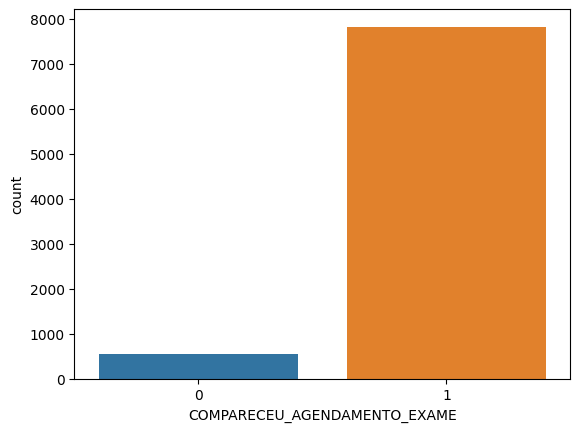

In [4]:
sns.countplot(data=data, x='COMPARECEU_AGENDAMENTO_EXAME')

In [5]:
import matplotlib.pyplot as plt

<AxesSubplot: >

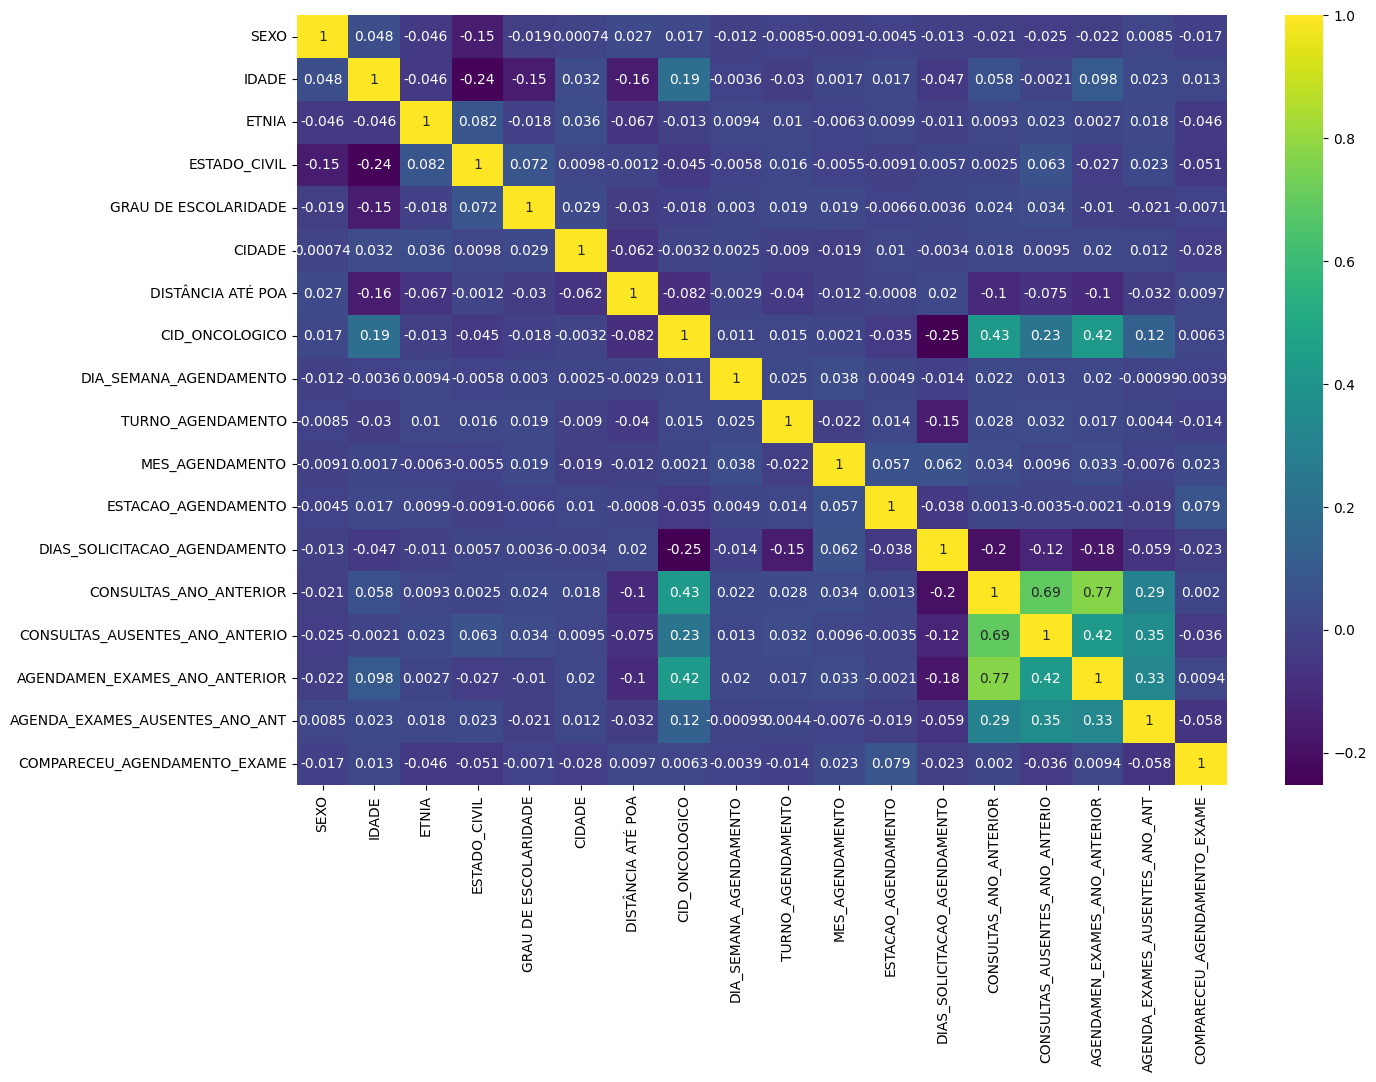

In [6]:
plt.figure(figsize=(15,10))
sns.heatmap(data= data.corr(), annot=True, cmap='viridis')

In [ ]:
fig, ax = plt.subplots(4,2, figsize=(16,16))
sns.distplot(data.var_1, bins = 20, ax=ax[0,0]) 
sns.distplot(data.var_2, bins = 20, ax=ax[0,1]) 
sns.distplot(data.var_3, bins = 20, ax=ax[1,0]) 
sns.distplot(data.var_4, bins = 20, ax=ax[1,1]) 
sns.distplot(data.var_5, bins = 20, ax=ax[2,0])
sns.distplot(data.var_6, bins = 20, ax=ax[2,1])
sns.distplot(data.var_7, bins = 20, ax=ax[3,0]) 
sns.distplot(data.var_8, bins = 20, ax=ax[3,1]) 

In [ ]:

correlations = X.corrwith(y)
correlations.sort_values(inplace=True)
correlations
ax = correlations.plot(kind='bar')
ax.set(ylim=[-.1, 0.1], ylabel='pearson correlation')

# X.corrwith(data.COMPARECEU_AGENDAMENTO_EXAME).plot.bar(figsize = (15, 10), title = "Correlation with Target", fontsize = 10,grid = True)

In [ ]:
sns.scatterplot(x=data.ESTACAO_AGENDAMENTO,y=y,hue=y)

In [ ]:
## Correlation Matrix
sns.set(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=0)

In [8]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

In [9]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, penalty='l2')
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix
# classifier = LogisticRegression(penalty='l2')
kf =  StratifiedKFold(n_splits=5)
scr = []
pipe = Pipeline([('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2'))])
for train, test in kf.split(X,y):
    Xtr,Xts = X.iloc[train,:],X.iloc[test,:]
    ytr,yts = y[train],y[test]
    pipe.fit(Xtr,ytr)
    ypr = pipe.predict(Xts)
    cm = confusion_matrix(yts,ypr,normalize='true')
    scr.append(np.sqrt(cm[0][0]*cm[1][1]))
    
print(scr)
    # classifier.fit(X_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
kf =  StratifiedKFold(n_splits=5)
scr = []
poly = PolynomialFeatures(degree=5)
pipe = Pipeline([(('poli',poly)),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2'))])
for train, test in kf.split(X,y):
    Xtr,Xts = X.iloc[train,:],X.iloc[test,:]
    ytr,yts = y[train],y[test]
    pipe.fit(Xtr,ytr)
    ypr = pipe.predict(Xts)
    cm = confusion_matrix(yts,ypr,normalize='true')
    # scr.append(np.sqrt(cm[0][0]*cm[1][1]))
    scr.append(accuracy_score(yts,ypr))
    
print(scr)
    # classifier.fit(X_train, y_train)

# scr2 = cross_val_score(pipe,X,y,cv = 5)
# print(scr2)

In [22]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


def minha_metrica(y_true, y_pred):
    threshold = 0.5  # Defina o threshold desejado

    # Calcule o true positive rate para o threshold dado
    tp = np.sum((y_true == 1) & (y_pred >= threshold))
    fn = np.sum((y_true == 1) & (y_pred < threshold))
    tpr = tp / (tp + fn)

    # Calcule o true negative rate para o threshold dado
    tn = np.sum((y_true == 0) & (y_pred < threshold))
    fp = np.sum((y_true == 0) & (y_pred >= threshold))
    tnr = tn / (tn + fp)

    # Calcule o produto dos passos 1 e 2
    product = tpr * tnr

    # Retorne a raiz quadrada do passo 3
    return np.sqrt(product)

my_scorer = make_scorer(minha_metrica,greater_is_better=True)

poly = PolynomialFeatures(degree=6)
pipe = Pipeline([(('poli',poly)),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',C = 10))])
cvr = cross_validate(pipe, X, y, cv=3, scoring=my_scorer, return_estimator=True)



In [23]:
estimators = cvr['estimator']
best_model = estimators[np.argmax(cvr['test_score'])]
# coefs = best_model.named_steps['modelo'].coef_[0]
cvr['test_score']


array([0.3004146 , 0.31561177, 0.29331883])

In [14]:
best_model.predict_proba(X_test)

array([[0.89908859, 0.10091141],
       [0.07566924, 0.92433076],
       [0.00255848, 0.99744152],
       ...,
       [0.01629468, 0.98370532],
       [0.0352696 , 0.9647304 ],
       [0.04010085, 0.95989915]])

In [ ]:
print(scores)

In [ ]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)
results = pd.DataFrame([['Logistic Regression (Lasso)', acc,prec,rec,f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
results

In [ ]:
cm = confusion_matrix(y_test, y_pred) # rows = truth, cols = prediction
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred)) 

In [ ]:
y_pred_prob = classifier.predict_proba(X_test)
from scipy import integrate
def capcurve(y_values, y_preds_proba):
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})
    xx = np.arange(num_count) / float(num_count - 1)
    
    y_cap = np.c_[y_values,y_preds_proba]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False).reset_index(level = y_cap_df_s.index.names, drop=True)
    
    print(y_cap_df_s.head(20))
    
    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1]) #add the first curve point (0,0) : for xx=0 we have yy=0
    
    percent = 0.5
    row_index = int(np.trunc(num_count * percent))
    
    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
        val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)
    
    sigma_ideal = 1 * xx[num_pos_obs - 1 ] / 2 + (xx[num_count - 1] - xx[num_pos_obs]) * 1
    sigma_model = integrate.simps(yy,xx)
    sigma_random = integrate.simps(xx,xx)
    
    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    ax.plot(ideal['x'],ideal['y'], color='grey', label='Perfect Model')
    ax.plot(xx,yy, color='red', label='User Model')
    ax.plot(xx,xx, color='blue', label='Random Model')
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1, label=str(val*100)+'% of positive obs at '+str(percent*100)+'%')
    
    plt.xlim(0, 1.02)
    plt.ylim(0, 1.25)
    plt.title("CAP Curve - a_r value ="+str(ar_value))
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()

In [ ]:
capcurve(y_test,y_pred_prob[:,1])

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator= classifier, X=X_train, y=y_train, cv=10)
accuracies.mean()
accuracies.std()
print('Logistic Regression (Lasso) Accuracy: %0.3f (+/- %0.3f)' % (accuracies.mean(), accuracies.std() * 2))

In [ ]:
pd.concat([pd.DataFrame(X_train.columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

In [ ]:
#Feature selection 
#Recursive feature elimination
from sklearn.feature_selection import RFE

#Select best feature 
rfe = RFE(classifier, n_features_to_select= None)
rfe = rfe.fit(X_train, y_train)

#Summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
X_train.columns[rfe.support_]

In [ ]:
# New Correlation Matrix
sns.set(style="white")

# Compute the correlation matrix
corr = X_train[X_train.columns[rfe.support_]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) 

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, penalty= 'l2')
classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test[X_train.columns[rfe.support_]])
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['Logistic Regression RFE (Lasso)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)
results

In [ ]:
y_pred_prob = classifier.predict_proba(X_test[X_train.columns[rfe.support_]])
capcurve(y_test,y_pred_prob[:,1])